In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from sentence_transformers import SentenceTransformer
import nibabel as nib
from nilearn.plotting import plot_glass_brain
from neurovlm.data import fetch_data

/Users/borng/code/lab_work/cmmWork/neurovlm2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction

This notebook introduces the `neurovlm` model architecture. The main components include:

1. Neuro-autoencoder
2. Text encoder
3. Text aligner

The neuro-autoencoder is trained using neuroimages from coordinates reported in 20k publications. Article titles are encoded using a pre-trained [sentence-transformer](https://sbert.net/). The text aligner is a network that maps the encoded text to the encoded neurovectors. This preserves the pretrained text encoder and circumvents the need for fine-tuning. These three components allows the prediction of neuroimages from short text queries.

![model](https://github.com/neurovlm/neurovlm_data/blob/08ad84c1460a4e7e46929ed5c8e89c6e462b9994/docs/model.png?raw=true)

## Model Architecture

The next tutorials steps through training the autoencoder and aligner from scratch. Here, the model structure is presented and pre-trained weights loaded. The model is presented here to share it's internal structure, but will be imported from `neurovlm.models` in future notebooks.

In [2]:
# from neurovlm.models import NeuroAutoEncoder, TextAligner
class NeuroAutoEncoder(nn.Module):
    def __init__(self):
        """Autoencoder architecture."""
        super().__init__()
        # Layer dimensions
        neuro_dim = 28_542
        h0 = 1024
        h1 = 512
        latent = 384
        # Networks
        self.encoder = nn.Sequential(
            nn.Linear(neuro_dim, h0),
            nn.ReLU(),
            nn.Linear(h0, h1),
            nn.Linear(h1, latent),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, h1),
            nn.ReLU(),
            nn.Linear(h1, h0),
            nn.ReLU(),
            nn.Linear(h0, neuro_dim),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.decoder(self.encoder(X))

class TextAligner(nn.Module):
    def __init__(self, latent_dim=384):
        """Aligner architecture."""
        super().__init__()
        self.aligner = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
        )
    def forward(self, X):
        return self.aligner(X)

## Text Queries

Load the pre-trained models and try a few text queries out. The decoder has a sigmoid output layer and the predicted neuroimages can be interpreted as probability of being associated with the text query.

In [21]:
# Load pre-trained
neuro_decoder = torch.load(
    "decoder_half.pt", weights_only=False
).to("cpu")

text_aligner = torch.load(
    "aligner_half.pt", weights_only=False
).to("cpu")

text_encoder = SentenceTransformer(
    "paraphrase-MiniLM-L3-v2"
).to("cpu")

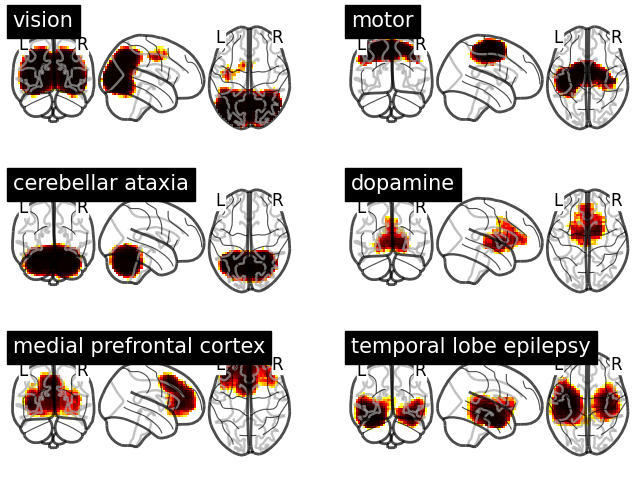

In [50]:
# Load mask and affine
data_dir = fetch_data()

mask, affine = np.load(
    f"{data_dir}/mask.npz", allow_pickle=True
).values()

# Query
queries = [
    "vision",
    "motor",
    "cerebellar ataxia",
    "dopamine",
    "medial prefrontal cortex",
    "temporal lobe epilepsy"
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))
axes = axes.flatten()

for i, query in enumerate(queries):
    
    # Encode text
    encoded_text = text_encoder.encode(
        query, convert_to_tensor=True
    ).half()
    
    # Align text
    aligned_text = text_aligner(encoded_text)
    
    # Decode brain
    neuro_pred = neuro_decoder(
        aligned_text
    ).detach().numpy()

    # Plot
    pred = np.zeros(mask.shape)
    pred[mask] = neuro_pred
    img = nib.Nifti1Image(pred, affine)
    plot_glass_brain(img, threshold=0.8, vmin=.8, vmax=1,
                     title=query, axes=axes[i]);

## Vector Projection

Vector projection is covered in the third notebook. Briefly, it is a method that can project a query vector onto the training set. This allows un- or under-researched queries to map to the most semantically similar in the training set.